# Credit Card Fraud Detection

Detecting fraudulent transactions is a major challenge for financial institutions. This project explores a Kaggle dataset containing anonymized credit card transactions. Our objective is to develop an effective Machine Learning model to identify fraudulent activities.

However, the task is complex. The fraud rate is minuscule (less than 0.2% of transactions), making the dataset heavily imbalanced. A simple accuracy score would be misleading. Therefore, we must focus on more relevant metrics like **Recall** and **Precision** to evaluate our model's ability to catch fraudulent transactions without generating too many false alarms.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    f1_score,
    precision_recall_curve,
    average_precision_score
)

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Data loading & Inspection

In [7]:
df = pd.read_csv('../data/creditcard.csv')

print(f'Shape : {df.shape}')
print(df.info())
print(f'Total of Null elements : {df.isna().sum().sum()}')

print(df.head())

Shape : (284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  fl

### Exploratory Data Analysis (EDA)

We now perform a quick exploration to better understand the dataset and the target distribution.
Since this is an imbalanced dataset, checking the target variable `Class` is crucial.


Counts:
 Class
0    284315
1       492
Name: count, dtype: int64

Percentages (%):
Class
0    99.827
1     0.173
Name: proportion, dtype: float64


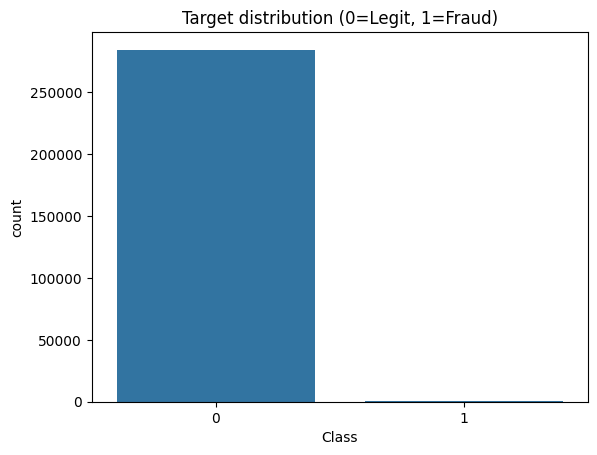

Amount skewness: 16.978


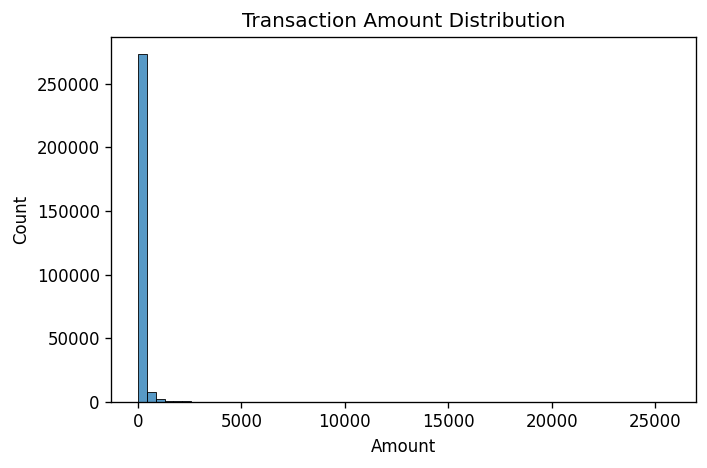

In [8]:
# Counts + percentages
class_counts = df["Class"].value_counts()
class_pct = df["Class"].value_counts(normalize=True) * 100

print(f"Counts:\n {class_counts}")
print(f"\nPercentages (%):\n{class_pct.round(3)}")

# Simple barplot
sns.countplot(x="Class", data=df)
plt.title("Target distribution (0=Legit, 1=Fraud)")
plt.show()


# Skewness (measure of asymmetry)
print("Amount skewness:", df["Amount"].skew().round(3))

# Histogram
plt.figure(figsize=(6,4), dpi=120)
sns.histplot(df["Amount"], bins=60, kde=False)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


#### EDA observations

- The dataset is **highly imbalanced**: only about 0.17% of the transactions are frauds.  
- The feature **Amount** is very skewed, which means scaling will be needed.  
- The feature **Time** does not show a clear pattern, but I will keep it for now.  

Overall, the dataset is clean (no missing values) but the imbalance makes the task challenging.  


### Pre-Processing
We can remove the Time column because it is just the time passed since the first transaction, it have no impact on the result.

In [9]:
X = df.drop(columns=["Class", 'Time'])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)

In [10]:
features_to_scale = ["Amount"]
features_passthrough = []
for i in X.columns:
    if i not in features_to_scale:
        features_passthrough.append(i)

preprocess = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), features_to_scale),
        ('passthrough', 'passthrough', features_passthrough)
    ]
)

---

## Logistic Regression

In [11]:
pipeline_LR = make_pipeline(
    preprocess,
    LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE)
)

param_grid_LR = {
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__C": [0.01, 0.1, 1, 10, 100],
    "logisticregression__solver": ["liblinear", "saga"]
}
grid_LR = GridSearchCV(
    estimator=pipeline_LR,
    param_grid=param_grid_LR,
    scoring="roc_auc",
    n_jobs=-1
)

grid_LR.fit(X_train, y_train)
print(f'Best params :\n{grid_LR.best_params_}')

best_LR = grid_LR.best_estimator_
y_pred_LR = best_LR.predict(X_test)
y_proba = best_LR.predict_proba(X_test)[:, 1]

Best params :
{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


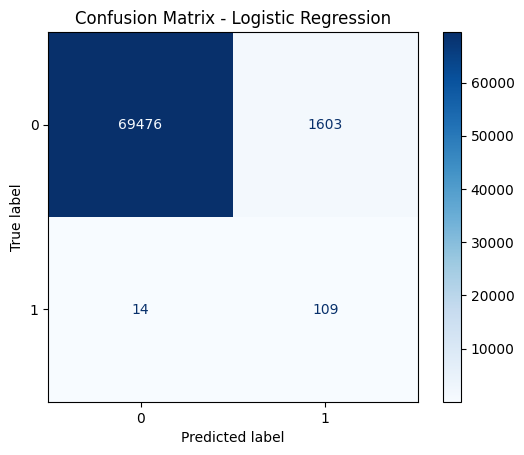

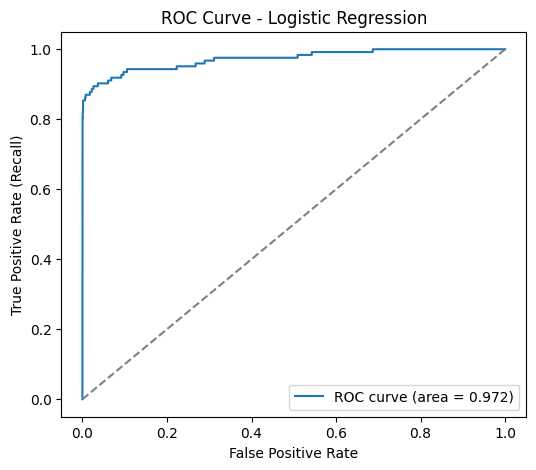

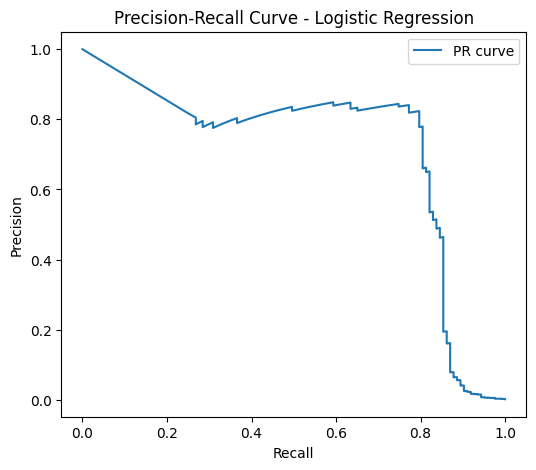

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("../images/elineconfusion_matrix_logreg.png", dpi=300, bbox_inches="tight")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.savefig("../images/elineroc_curve_logreg.png", dpi=300, bbox_inches="tight")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.savefig("../images/elinepr_curve_logreg.png", dpi=300, bbox_inches="tight")
plt.show()

- The best model was found with **L1 penalty** and **C=0.01**.  
- It achieves a **ROC-AUC of 0.97**, which is a very good overall performance.  
- The model has a **high recall (≈88%)**, meaning it detects most fraud cases.  
- However, the **precision is very low (≈6%)**, which means there are many false positives.  

Logistic Regression is a strong **baseline** model for fraud detection: it captures most fraudulent cases, but it is not precise enough for real-world use.  
The next step is to try **Random Forest** to improve precision while keeping a good recall.  

---

## Random Forest

Before running hyperparameter tuning, I start with a quick **baseline Random Forest** model.  
The goal is to get a first idea of its performance on fraud detection, using default parameters  
(`n_estimators=100`, `class_weight="balanced"`).  

I evaluate it with two key metrics:  
- **ROC-AUC**: overall model performance (higher is better).  
- **Recall**: ability to detect fraud cases (sensitivity).  


In [13]:
baseline_RF = make_pipeline(
    preprocess,
    RandomForestClassifier(
        n_estimators=100, 
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

baseline_RF.fit(X_train, y_train)

y_pred_RF = baseline_RF.predict(X_test)
y_proba_RF = baseline_RF.predict_proba(X_test)[:, 1]

print(f"Baseline RF ROC-AUC: {round(roc_auc_score(y_test, y_proba_RF), 4)}")
print(f"Baseline RF Recall : {round(recall_score(y_test, y_pred_RF), 4)}")

Baseline RF ROC-AUC: 0.9417
Baseline RF Recall : 0.7154


The baseline Random Forest achieves a **ROC-AUC of ~0.94** and a **Recall of ~0.71**.  

This is weaker than Logistic Regression in terms of recall, but it already shows a  
reasonable performance without any tuning.  

Next step: use **Validation Curve** and **RandomizedSearchCV** to improve the model.  


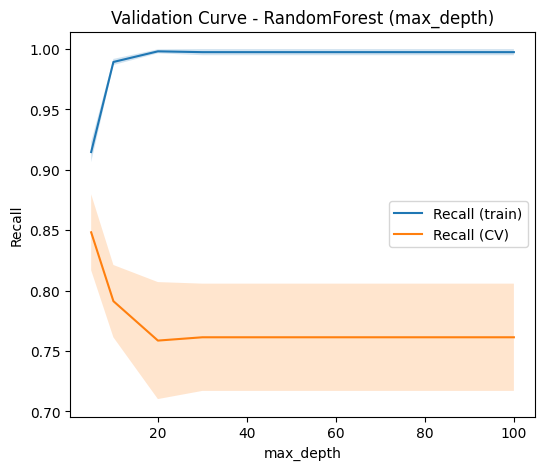

In [14]:
param_range = [5, 10, 20, 30, 40, 60, 80, 100]

train_scores, val_scores = validation_curve(
    estimator=baseline_RF,
    X=X_train, y=y_train,
    param_name="randomforestclassifier__max_depth",
    param_range=param_range,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

# Moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(6,5))
plt.plot(param_range, train_mean, label="Recall (train)")
plt.plot(param_range, val_mean, label="Recall (CV)")
plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(param_range, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.title("Validation Curve - RandomForest (max_depth)")
plt.legend()
plt.show()

- **Recall (train)** increases strongly with `max_depth`, but always remains higher than Recall in CV → classic sign of **overfitting**.  
- **Recall (CV)** reaches its maximum at intermediate depths (`max_depth ≈ 10–20`) then stagnates or slightly decreases.  
- Beyond `max_depth=30`, the train–CV gap widens → no gain on validation data.  

For the next steps, we retain that **very large depths bring no benefit** and encourage overfitting.  
We let RandomizedSearchCV explore the space, but we expect good results for `max_depth` around **10–30**.


In [15]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_distributions = {
    "randomforestclassifier__n_estimators": randint(200, 500),
    "randomforestclassifier__max_depth": randint(10, 31),
    "randomforestclassifier__min_samples_leaf": randint(2, 6),
    "randomforestclassifier__max_features": ["sqrt", "log2"],
    "randomforestclassifier__max_samples": [0.5, 0.75, None]
}

rnd_fast = RandomizedSearchCV(
    estimator=baseline_RF,
    param_distributions=param_distributions,
    n_iter=10,
    scoring="roc_auc",
    refit=True,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)
rnd_fast.fit(X_train, y_train)
print("Best params:", rnd_fast.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'randomforestclassifier__max_depth': 14, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_samples': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 366}


#### Tuned Random Forest - Evaluation

- Using the best RF model.
- Probabilities converted to predictions with a 0.5 threshold.
- Metrics computed: **ROC-AUC, PR-AUC, Recall, Precision, F1**.
- Results compared side by side with Logistic Regression.


In [16]:
rf_best = rnd_fast.best_estimator_

y_proba_rf = rf_best.predict_proba(X_test)[:, 1]
y_pred_rf  = (y_proba_rf >= 0.5).astype(int)


def eval_cls(y_true, y_pred, y_proba):
    return {
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
        "Recall": recall_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred),
    }

lr_results = eval_cls(y_test, y_pred_LR, y_proba)
rf_results = eval_cls(y_test, y_pred_rf, y_proba_rf)

compare_df = pd.DataFrame(
    [lr_results, rf_results],
    index=["Logistic Regression", "Random Forest (tuned)"]
).round(4)

compare_df

,ROC-AUC,PR-AUC,Recall,Precision,F1
Logistic Regression,0.9724,0.6929,0.8862,0.0637,0.1188
Random Forest (tuned),0.9738,0.8321,0.7724,0.9048,0.8333


- **Logistic Regression** achieves slightly higher **Recall** (better at catching frauds), but at the cost of very low Precision.  
- **Random Forest** provides a much better balance with very high **Precision** and a strong **F1-score**, while keeping ROC-AUC close to Logistic Regression.  
- Overall, **Random Forest is the stronger model** here, as it captures frauds with far fewer false positives.

Next, I will try the model **XGBoost** to check if it performs even better which, in theory, it should.

---

## XGBoost

To handle class imbalance (as fraud is a minority class), I split the training set into training and validation sets (≈15%). The validation set will be used for early stopping, not as a test set.

In [17]:
import xgboost as xgb
from xgboost import XGBClassifier

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE)

# I handle class imbalance (fraud = minority class)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos = neg / pos

I start with a simple Baseline model

In [41]:
xgb_baseline = make_pipeline(
    preprocess,
    XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos,
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

xgb_baseline.fit(X_tr, y_tr)

y_proba_xgb = xgb_baseline.predict_proba(X_test)[:, 1]
y_pred_xgb  = (y_proba_xgb >= 0.5).astype(int)

xgb_results = eval_cls(y_test, y_pred_xgb, y_proba_xgb)

if "XGBoost (baseline)" in compare_df.index:
    compare_df = compare_df.drop("XGBoost (baseline)")

compare_df.loc["XGBoost (baseline)", compare_df.columns] = \
    pd.Series(xgb_results)[compare_df.columns].values

compare_df


,ROC-AUC,PR-AUC,Recall,Precision,F1
Logistic Regression,0.972400,0.692900,0.886200,0.063700,0.118800
Random Forest (tuned),0.973800,0.832100,0.772400,0.904800,0.833300
XGBoost (baseline),0.983136,0.860783,0.837398,0.830645,0.834008


- **Logistic Regression** : slightly higher Recall, but at the cost of very low Precision.  
- **Random Forest** : strong balance, higher Precision and F1 compared to Logistic Regression.  
- **XGBoost** : outperforms both in overall trade-off, with solid PR-AUC and Recall.  
- This confirms that **XGBoost is the best model so far** for fraud detection on this dataset.  

Next step: perform a quick **hyperparameter tuning** on XGBoost to check if we can push performance further.

In [42]:
xgb_pipe = make_pipeline(
    preprocess,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scale_pos_weight=scale_pos
    )
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_dist = {
    "xgbclassifier__n_estimators": randint(400, 1601),
    "xgbclassifier__max_depth": randint(3, 10),
    "xgbclassifier__min_child_weight": randint(1, 11),
    "xgbclassifier__learning_rate": uniform(0.02, 0.18),
    "xgbclassifier__subsample": uniform(0.6, 0.4),
    "xgbclassifier__colsample_bytree": uniform(0.6, 0.4),
    "xgbclassifier__gamma": uniform(0.0, 5.0),
    "xgbclassifier__reg_lambda": uniform(0.0, 10.0)
}

rnd = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="average_precision", # PR-AUC
    cv=cv,
    refit=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rnd.fit(X_train, y_train)
print("Best (randomized) params:\n", rnd.best_params_)
print("Best CV PR-AUC:", rnd.best_score_)
best_rnd = rnd.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best (randomized) params:
 {'xgbclassifier__colsample_bytree': 0.8010716092915446, 'xgbclassifier__gamma': 0.25739375624994676, 'xgbclassifier__learning_rate': 0.07015636356259006, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 1553, 'xgbclassifier__reg_lambda': 5.309345833171363, 'xgbclassifier__subsample': 0.7791132658292367}
Best CV PR-AUC: 0.8531788619904624


After the wide exploration with RandomizedSearchCV, we now run a more **focused GridSearchCV**.  
The grid is built around the best parameters found previously, exploring only small variations.  
The goal is to refine the model hyperparameters and squeeze the last performance gains.

In [44]:
best = rnd.best_params_

grid_params = {
    "xgbclassifier__max_depth":        [2, 3, 4],
    "xgbclassifier__min_child_weight": [1, 2],
    "xgbclassifier__learning_rate":    [0.05, 0.07, 0.09],
    "xgbclassifier__subsample":        [0.7, 0.8, 0.9],
    # I fix the other values found by RandomizedSearchCV
    "xgbclassifier__colsample_bytree": [best["xgbclassifier__colsample_bytree"]],
    "xgbclassifier__gamma":            [best["xgbclassifier__gamma"]],
    "xgbclassifier__reg_lambda":       [best["xgbclassifier__reg_lambda"]],
    "xgbclassifier__n_estimators":     [best["xgbclassifier__n_estimators"]],
}

grid = GridSearchCV(
    estimator=rnd.best_estimator_,
    param_grid=grid_params,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best (grid) params:\n", grid.best_params_)
print("Best CV PR-AUC:", grid.best_score_)

y_proba_xgb_grid = grid.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_xgb_grid  = (y_proba_xgb_grid >= 0.5).astype(int)
xgb_grid_results = eval_cls(y_test, y_pred_xgb_grid, y_proba_xgb_grid)

compare_df.loc["XGBoost (grid)", compare_df.columns] = \
    pd.Series(xgb_grid_results)[compare_df.columns].values
compare_df = compare_df.round(4)

compare_df

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best (grid) params:
 {'xgbclassifier__colsample_bytree': 0.8010716092915446, 'xgbclassifier__gamma': 0.25739375624994676, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__n_estimators': 1553, 'xgbclassifier__reg_lambda': 5.309345833171363, 'xgbclassifier__subsample': 0.9}
Best CV PR-AUC: 0.8559424940789025


,ROC-AUC,PR-AUC,Recall,Precision,F1
Logistic Regression,0.9724,0.6929,0.8862,0.0637,0.1188
Random Forest (tuned),0.9738,0.8321,0.7724,0.9048,0.8333
XGBoost (baseline),0.9831,0.8608,0.8374,0.8306,0.8340
XGBoost (grid),0.9837,0.8623,0.8049,0.8684,0.8354


After RandomizedSearchCV and GridSearchCV, we retrain XGBoost one last time:

- We split the training set into **train + validation**.
- The model is refit with a **high number of trees (2000)**.
- We use **early stopping**: training stops automatically if there is no improvement
  on the validation set for 50 rounds.
- This ensures the model uses the **optimal number of trees** and avoids overfitting.

The final model is then evaluated on the test set with the tuned threshold,
giving us the best balance between Precision and Recall.

In [51]:
from sklearn.base import clone

# Split training data for Early Stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

# Preprocess
prep = clone(preprocess).fit(X_tr, y_tr)
X_tr_p, X_val_p = prep.transform(X_tr), prep.transform(X_val)

# Clone best model from GridSearch
xgb_final = clone(grid.best_estimator_.named_steps["xgbclassifier"])
xgb_final.set_params(
    n_estimators=2000,
    early_stopping_rounds=50,
    verbosity=0,
    eval_metric="aucpr"
)

# Fit with early stopping
xgb_final.fit(
    X_tr_p, y_tr,
    eval_set=[(X_val_p, y_val)],
    verbose=False
)

print("Best iteration:", xgb_final.best_iteration)
print("Best validation aucpr:", xgb_final.best_score)

final_model = make_pipeline(prep, xgb_final)

# Find optimal threshold on validation
y_val_proba = xgb_final.predict_proba(X_val_p)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall : {recalls[best_idx]:.3f}")
print(f"F1 : {f1_scores[best_idx]:.3f}")


# Evaluate final model on test set
y_proba_final = final_model.predict_proba(X_test)[:, 1]
y_pred_final  = (y_proba_final >= best_threshold).astype(int)

xgb_final_results = eval_cls(y_test, y_pred_final, y_proba_final)

compare_df.loc["XGBoost (Final)"] = \
    pd.Series(xgb_final_results)[compare_df.columns].values
compare_df = compare_df.round(4)

compare_df

Best iteration: 954
Best validation aucpr: 0.8396965763773818
Best threshold: 0.855
Precision: 0.967
Recall : 0.797
F1 : 0.874


,ROC-AUC,PR-AUC,Recall,Precision,F1
Logistic Regression,0.9724,0.6929,0.8862,0.0637,0.1188
Random Forest (tuned),0.9738,0.8321,0.7724,0.9048,0.8333
XGBoost (baseline),0.9831,0.8608,0.8374,0.8306,0.8340
XGBoost (grid),0.9837,0.8623,0.8049,0.8684,0.8354
XGBoost (Final),0.9833,0.8574,0.7967,0.9333,0.8596


### Final Results - Model Comparison

- **Logistic Regression**: high Recall but extremely poor Precision, not usable in practice.  
- **Random Forest (tuned)**: strong balance, Precision and F1 much higher than Logistic Regression.  
- **XGBoost (baseline)**: already very solid, outperforming Random Forest.  
- **XGBoost (grid)**: slight improvement from the baseline, thanks to fine-tuned hyperparameters.  
- **XGBoost (Final)**: best model overall, with a tuned threshold that delivers:
  - Precision ≈ 0.93  
  - F1 ≈ 0.86  
  - Excellent trade-off between catching frauds (Recall) and avoiding false alarms (Precision).  

This confirms that **XGBoost with tuned hyperparameters, early stopping, and an optimized threshold is the best model for fraud detection** on this dataset.

---


In [56]:
import joblib

joblib.dump(final_model, "../models/xgb_final_model.pkl")

['../models/xgb_final_model.pkl']

We save the full pipeline (`preprocess + XGBoost Final`) using **joblib**.  
This allows us to reload the trained model later without retraining, and use it directly for predictions.  

The model is saved in the `models/` folder as `xgb_final_model.pkl`.